In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 12.6.1


# Multi-Path Effect

## Introduction

Multipath effect in radar is a phenomenon where radar signals take multiple paths to reach the target and return to the receiver. This can occur when signals are reflected, scattered, or refracted by various objects or surfaces in the environment, resulting in multiple delayed echoes reaching the radar receiver. The multipath effect can have significant implications on radar performance and accuracy. Here's a brief introduction to this concept:

**1. Reflection and Scattering:** When radar signals encounter surfaces or objects, they can be reflected or scattered in different directions. Some of these reflected signals may return to the radar receiver, causing the radar to receive multiple echoes from different paths.

**2. Delayed Echoes:** Each path the signal takes introduces a time delay in the received signal. These time delays can vary based on the length of each path, leading to differences in the time it takes for the radar signal to return. As a result, the radar receives multiple echoes at different times.

**3. Signal Distortion:** Multipath effect can distort the received radar signal, making it challenging to accurately interpret and locate the target. The radar may perceive the target to be at a different location or with altered characteristics due to these multiple echoes.

**4. Mitigation Techniques:** Radar systems employ various techniques to mitigate the multipath effect. These include advanced signal processing algorithms, antenna design, and the use of multiple antennas to improve signal discrimination and reject unwanted echoes.

**5. Impact on Accuracy:** Understanding and compensating for the multipath effect is crucial for maintaining radar accuracy, especially in environments with reflective surfaces, clutter, or complex terrain. Failure to account for multipath can lead to false detections or reduced target tracking precision.

In summary, the multipath effect in radar occurs when signals take multiple paths to reach the target and return to the receiver due to reflections and scattering. It introduces time delays and signal distortion, which can affect radar accuracy. Radar systems employ various techniques to mitigate this effect and ensure reliable target detection and tracking.

In this example, we will employ [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/)'s ray tracing capabilities to demonstrate how vertical multipath effects from the ground can impact the received signal amplitude in an FMCW radar system.

## Create Radar Model

Firstly, import the required modules from `radarsimpy`. `numpy` will also be needed in this example.


In [2]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### Transmitter

Setup the basic transmitter parameters through [Transmitter](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-transmitter) module.

#### Define a Radar Transmitter

As shown in the diagram below, `f` and `t` are used to define the waveform modulation. For a linear frequency-modulated continuous waveform (FMCW), it can be specified as `f = [fstart, fend]` and `t = [tstart, tend]`. If `t` is a single number `t = t0`, which is equivalent to `t = [0, t0]`. The bandwidth of the FMCW is `abs(fstart - fend)`. `prp` is the pulse repetition period, and `prp >= (tend - tstart)`.

```
|                       prp
|                  +-----------+
|
|            +---f[1]--->  /            /            /
|                         /            /            /
|                        /            /            /
|                       /            /            /
|                      /            /            /     ...
|                     /            /            /
|                    /            /            /
|                   /            /            /
|      +---f[0]--->/            /            /
|
|                  +-------+
|                 t[0]    t[1]
```


In [3]:
tx_channel = dict(
    location=(0, 0, 0),
)

tx = Transmitter(
    f=[76.5e9 - 80e6, 76.5e9 + 80e6],
    t=20e-6,
    tx_power=15,
    prp=100e-6,
    pulses=1,
    channels=[tx_channel],
)

### Receiver

Setup the receiver parameters through [Receiver](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-receiver) module.

#### Define a Radar Receiver

- `fs` – Sampling rate (sps)
- `noise_figure` – Noise figure (dB)
- `rf_gain` – Total RF gain (dB)
- `load_resistor` – Load resistor to convert power to voltage (Ohm)
- `baseband_gain` – Total baseband gain (dB)


In [4]:
rx_channel = dict(
    location=(0, 0, 0),
)

rx = Receiver(
    fs=20e6,
    noise_figure=8,
    rf_gain=20,
    load_resistor=1000,
    baseband_gain=80,
    channels=[rx_channel],
)

### Radar System

Use the defined transmitter and receiver to create the radar system.


In [5]:
radar = Radar(transmitter=tx, receiver=rx)

## Case 1: A corner reflector with ground surface


In [6]:
from radarsimpy.simulator import sim_radar
from scipy import signal
import radarsimpy.processing as proc
import time


target_1 = {"model": "../models/cr.stl", "location": (300, 0, 0), "speed": (-1, 0, 0)}

target_2 = {
    "model": "../models/surface_400x400.stl",
    "location": (0, 0, -0.5),
    "speed": (0, 0, 0),
    "permittivity": 3.2 + 0.1j,
    "is_ground": True,
}
targets = [target_1, target_2]

tic = time.time()
data = sim_radar(radar, targets, density=0.5, frame_time=np.arange(0, 290, 1))
baseband = data["baseband"]

range_window = signal.windows.chebwin(radar.sample_prop["samples_per_pulse"], at=60)
range_profile = proc.range_fft(baseband, range_window)

amp_multi = np.max(20 * np.log10(np.abs(range_profile)), axis=2)
toc = time.time()
print("Exec time:", toc - tic, "s")

Exec time: 3.452235221862793 s


## Case 2: A corner reflector without ground surface


In [7]:
target_1 = {"model": "../models/cr.stl", "location": (300, 0, 0), "speed": (-1, 0, 0)}

targets = [target_1]

data = sim_radar(radar, targets, density=0.5, frame_time=np.arange(0, 290, 1))
baseband = data["baseband"]

range_window = signal.windows.chebwin(radar.sample_prop["samples_per_pulse"], at=60)
range_profile = proc.range_fft(baseband, range_window)

amp_single = np.max(20 * np.log10(np.abs(range_profile)), axis=2)

## Results

Duo to the multi-path:

- Path 1: Tx -> Corner reflecor -> Rx
- Path 2: Tx -> Ground -> Corner reflecor -> Ground -> Rx
- Path 3: Tx -> Ground -> Corner reflecor -> Rx
- Path 4: Tx -> Corner reflecor -> Ground -> Rx

A fluctuation can be observed from the received target amplitude versus the target range.


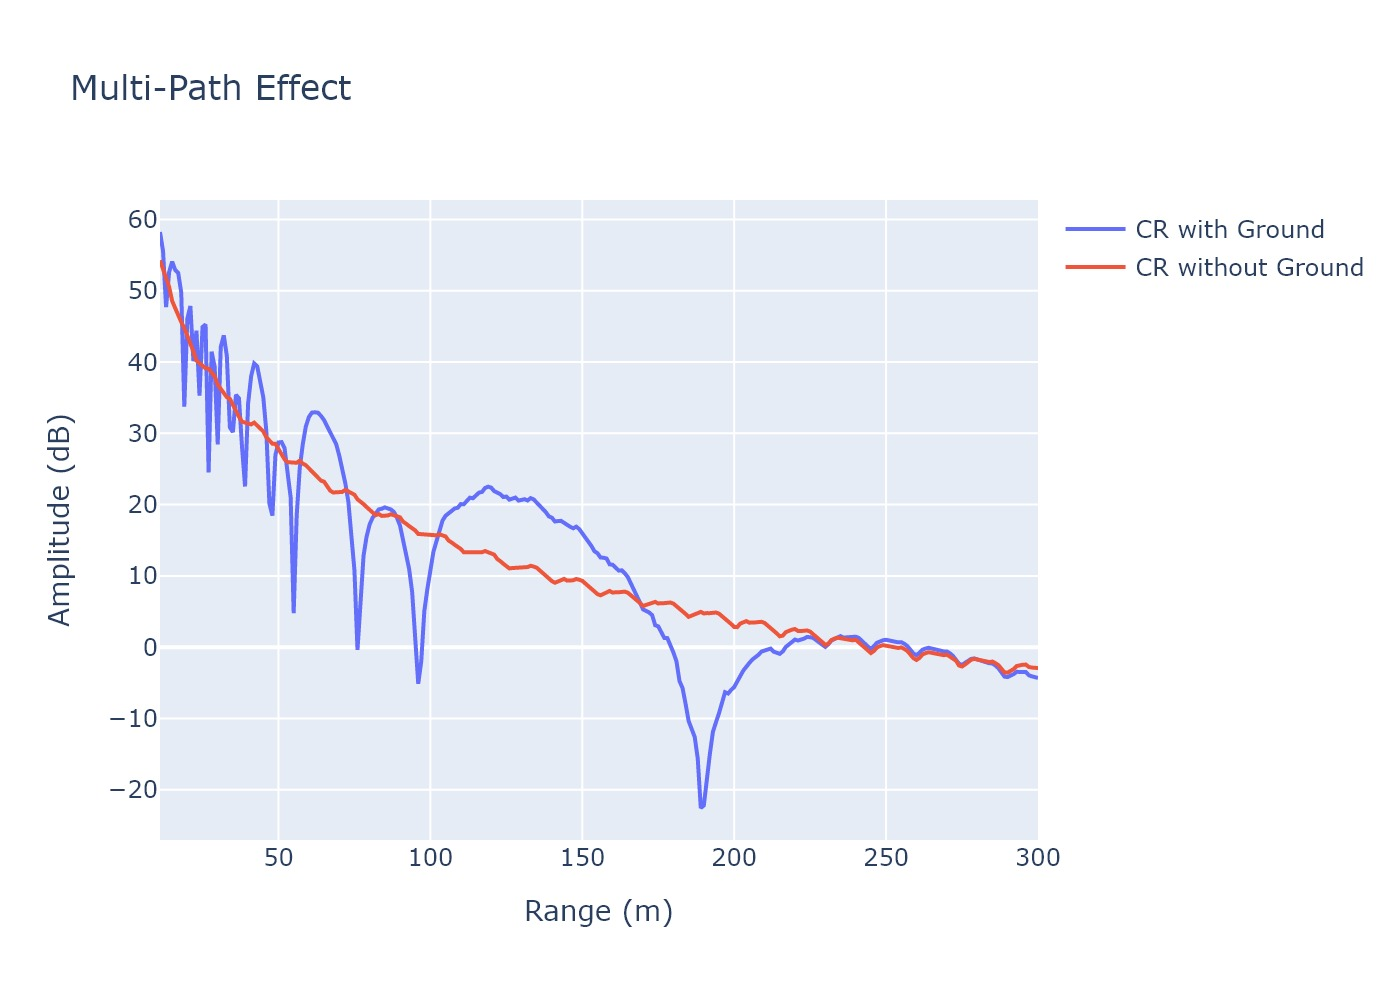

In [8]:
import plotly.graph_objs as go
from IPython.display import Image

t_range = 10 + np.arange(290, 0, -1) * 1

fig = go.Figure()

fig.add_trace(go.Scatter(x=t_range, y=amp_multi[:, 0], name="CR with Ground"))
fig.add_trace(go.Scatter(x=t_range, y=amp_single[:, 0], name="CR without Ground"))

fig.update_layout(
    title="Multi-Path Effect",
    yaxis=dict(title="Amplitude (dB)"),
    xaxis=dict(title="Range (m)"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))